# Problem Statement

Using publicly available data at data.gov.sg please create a model pipeline to forecast (upcoming 3 hours) the traffic flow at the specified location (latitude: 1.357098686 longitude: 103.902042), for a specified time of day. The solution must have the following components:

 

* Estimation of historical traffic flow, using image data sets available here (https://data.gov.sg/dataset/traffic-images )
* Use the pipeline from (1) and weather data (https://data.gov.sg/dataset/realtime-weather-readings), to forecast the traffic flow at the specified location at a specified time of day

## Data Exploration

* First, of all the problem looks very interesting. 
* Let us explore the images on the given latitude, longitude location. 
* The image url on the lat,long is stored for inference process
* This code scrapes through the json and gets the image URL for the particular latitude and longitude


### Traffic Camera Images

The provided traffic camera location (lat,long) can be accessed using the "get request" and providing the date as input.  
* The JSON response looks like this: <br>

    {
      "timestamp": "2021-08-29T10:10:09+08:00",
      "cameras": [
        {
          "timestamp": "2021-08-29T10:07:49+08:00",
          "image": "https://images.data.gov.sg/api/traffic-images/2021/08/0dc02207-d696-4dcd-a0b7-13e4946e33cf.jpg",
          "location": {
            "latitude": 1.28569398886979,
            "longitude": 103.837524510188
          },
          "camera_id": "1704",
          "image_metadata": {
            "height": 480,
            "width": 640,
            "md5": "fb999bc0cc315bcbf158941c71fe1f63"
          }
        }
        }
      ]
    }
  ],
  "api_info": {
    "status": "healthy"
  }
}


* Let's use the "image" url and check the camera images at the given location.

<img src="https://images.data.gov.sg/api/traffic-images/2021/08/0abeaddf-2898-4240-8f10-aade2ee6b883.jpg" width="500" align="center">

### Weather Data

The weather data JSON file looks like this: <br>
{
  "metadata": {
    "stations": [
      {
        "id": "S50",
        "device_id": "S50",
        "name": "Clementi Road",
        "location": {
          "latitude": 1.3337,
          "longitude": 103.7768
        }
      },
      {
        "id": "S107",
        "device_id": "S107",
        "name": "East Coast Parkway",
        "location": {
          "latitude": 1.3135,
          "longitude": 103.9625
        }
      },
      {
        "id": "S43",
        "device_id": "S43",
        "name": "Kim Chuan Road",
        "location": {
          "latitude": 1.3399,
          "longitude": 103.8878
        }
      },

However, the given (lat,long) information is not availble direcly. We can find the close proximity location to the given location. i.e., closest to (latitude: 1.357098686 longitude: 103.902042)

## Solution steps

* As it is evident that in order to get the details of traffic, we are required to do object detection on the images that are available. The steps required to solve this problem are as follows:
  1. Get the historical data using the API calls provided by data.gov.sg.
  2. Perform object detection on the images, identifying the vehicles that passes.
  3. Create a data frame, using the information such as vehicle count, date, etc. 
  4. Using the historical data, use LSTM to forecast the traffic.

## Data Collection

The data is collected for the following dates:
* 29/07/2021 to 01/08/2021. 
* Further data can be added to the algorithm with further GPU compute and the API's for getting the data.
* The object detection algorithm used is YOLOv5 which is the SoTA in object detection.

### Object detection 

Setup from github and install the requirements

In [1]:
import pandas as pd
import torch


In [2]:
# !git clone https://github.com/ultralytics/yolov5
# %cd yolov5
# !pip install -r requirements.txt

* It has been observed that yolo5l (yolo5 large) is better in performance than yolo5s or yolo5m on this dataset
* Let's check the inference made on an image URL

In [3]:
# img_url = 'https://images.data.gov.sg/api/traffic-images/2021/08/0abeaddf-2898-4240-8f10-aade2ee6b883.jpg'
# # Model
# model = torch.hub.load('ultralytics/yolov5', 'yolov5l')  # or yolov5m, yolov5l, yolov5x, custom

# # Inference
# results = model(img_url)

# # Results
# results.show()

* Code for data collection according to the dates. 
* The object detection algorithm (YOLOv5) is used to get the vehicle count.
* Other details such as image URL and object detection results are also stored.  

In [4]:
# import requests
# import urllib
# date_list = []
# img_list = []
# img_url_list = []
# car_count_list = []
# car_conf_list = []
# for m in range(0,23):
#     if m<10:
#         m='0'+str(m)
#     else:
#         m=str(m)
#     for j in range(1,60):

#         if j<10:
#             j='0'+str(j)
#         else:
#             j=str(j)
#         url = r'https://api.data.gov.sg/v1/transport/traffic-images?date_time=2021-07-28T'+m+'%3A'+j+'%3A10'
#         print(url)
#         date = '2021-07-28T'+m+':'+j+':10'
#         resp = requests.get(url)
#         json1 = resp.json()
        
#         for i in range(0,len(json1['items'][0]['cameras'])):
#             # print(json1['items'][0]['cameras'][i]['location'])
#             if (json1['items'][0]['cameras'][i]['location']['latitude']==1.357098686) & (json1['items'][0]['cameras'][i]['location']['longitude']==103.902042):
#                 img_url = json1['items'][0]['cameras'][i]['image']
#                 img_name = img_url.split('/')[-1]
#                 try:
#                     img_list.append(img_name)
#                     date_list.append(date)
#                     img_url_list.append(img_url)
#                     results = model(img_url)

#                     # Results
#                     results.show()
#                     tmp = results.pandas()
#                     car_count_list.append(tmp.pred[0].shape[0])
#                     car_conf_list.append(tmp.pred)
#                     print(img_url)
#                     r = requests.get(img_url)
            
#                     # with open(img_name, "wb") as f:
#                     #     f.write(r.content)
#                 except:
#                     pass

# traffic_data1 = pd.DataFrame({'date':date_list, 'image_URL':img_url_list, 'image_names':img_list, 'car_count':car_count_list, 'car_conf':car_conf_list})
# traffic_data1.to_excel('traffic_data.xlsx')

## Model building - Traffic Forecast

The algorithm that will be used here is LSTM. LSTM stands for long short term memory.It has very good applications in Time series Anomaly detection and Forecasting. 

Import required packages

In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data Ingestion

In [6]:
# The data file can be downloaded from 'https://github.com/gomathyshankar/trafficForecast/blob/main/traffic_data_Final.xlsx'

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
df = pd.read_excel('/content/gdrive/My Drive/traffic_data_Final.xlsx')

Convert the date type to the convenient format.

In [8]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M")
df['date'] = df['date'].astype('datetime64[m]')
df.head()

,Unnamed: 0,date,image_URL,image_names,car_count,car_conf
0,0,2021-07-29 00:01:00,https://images.data.gov.sg/api/traffic-images/...,02a8066e-5a8e-4524-a058-6e8f607bb86d.jpg,0,"[tensor([], device='cuda:0', size=(0, 6))]"
1,1,2021-07-29 00:02:00,https://images.data.gov.sg/api/traffic-images/...,02a8066e-5a8e-4524-a058-6e8f607bb86d.jpg,0,"[tensor([], device='cuda:0', size=(0, 6))]"
2,2,2021-07-29 00:03:00,https://images.data.gov.sg/api/traffic-images/...,02a8066e-5a8e-4524-a058-6e8f607bb86d.jpg,0,"[tensor([], device='cuda:0', size=(0, 6))]"
3,3,2021-07-29 00:04:00,https://images.data.gov.sg/api/traffic-images/...,02a8066e-5a8e-4524-a058-6e8f607bb86d.jpg,0,"[tensor([], device='cuda:0', size=(0, 6))]"
4,4,2021-07-29 00:05:00,https://images.data.gov.sg/api/traffic-images/...,02a8066e-5a8e-4524-a058-6e8f607bb86d.jpg,0,"[tensor([], device='cuda:0', size=(0, 6))]"


Plot the time series with "date" as x and "car count" as y axis

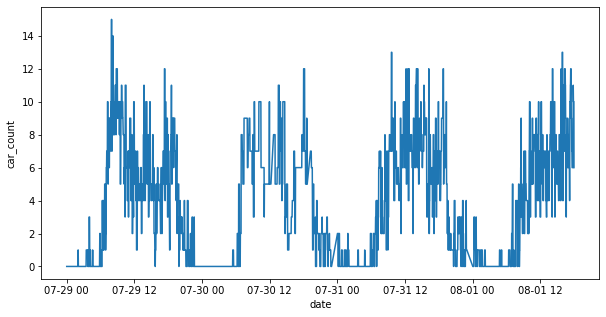

In [9]:
plt.figure(figsize=(10,5))

sns.lineplot(data=df, x='date', y='car_count')


Resample the date to 5 minute intervals. 

In [10]:
time_index = pd.date_range(start="2021-07-29 00:00:00",end='2021-08-01 17:00:00',freq='5T')

df_resampled = pd.DataFrame(index=time_index)
df_resampled['date'] = pd.to_datetime(df_resampled.index, format="%Y-%m-%d %H:%M")
df_resampled['date'] = df_resampled['date'].astype('datetime64[m]')

df_resampled = df_resampled.merge(df, on=['date'], how='left')

df_resampled = df_resampled.interpolate('ffill')
df_resampled = df_resampled.fillna(method='ffill')
df_resampled = df_resampled.bfill().ffill()
# sns.lineplot(data=df_resampled, x='date', y='car_count')

Observe the seasonal pattern and the trend. There is clearly a trend.

<Figure size 720x360 with 0 Axes>

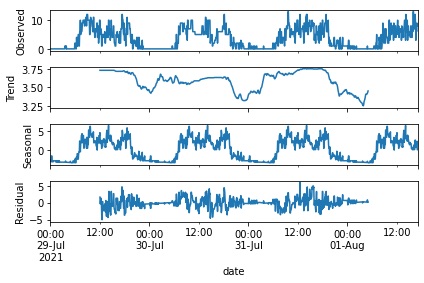

In [11]:
df_resampled = df_resampled.set_index('date')
df_resampled.index.freq = '5T'
a = seasonal_decompose(df_resampled['car_count'], model = "add", freq = ((24*60)//5))
plt.figure(figsize=(10,5))

a.plot();

The seasonality plot is shown below. The seasonality shows that the traffic is minimal in the night time. 

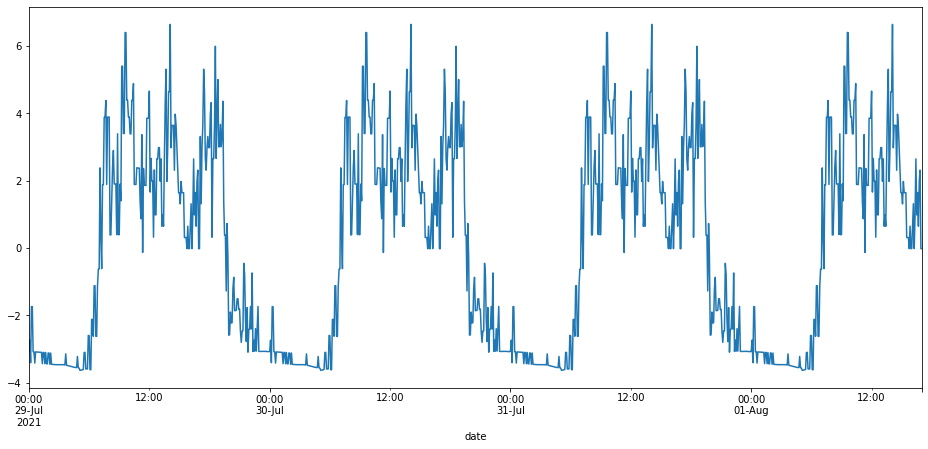

In [12]:
plt.figure(figsize = (16,7))
a.seasonal.plot();

In [13]:
df_resampled = df_resampled.drop(columns=['image_URL','image_names','car_conf','Unnamed: 0'])

Prepare the training data and test data. Here the test sample size is 24 since the required forecast period is 3 hours. The data is in the interval of 5 minutes. 
Due to limited data availability, we forecast for 2 hours i.e., window size of 24. 

In [14]:
train_data = df_resampled[:len(df_resampled)-24]
test_data = df_resampled[len(df_resampled)-24:]

Use the min max scaler as a preprocessing step for LSTM.


In [15]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)


The lag feature window has to be defined. The lag window can be modified according to the data. It is defined as n_input. 

In [16]:
n_input = 120
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


The LSTM Model has following layers:
* Activation layer - relu
* Dense layer
* Optimizer - Adam 
* Loss function - Mean squared error

In [17]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [18]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


Train the LSTM model. The model is trained for a few epochs. The metrics observed are Mean Squared Error (MSE), Root Mean Squared Error (RMSE). 

Epoch 1/5
925/925 [==============================] - 78s 83ms/step - loss: 0.0267
Epoch 2/5
925/925 [==============================] - 76s 82ms/step - loss: 0.0213
Epoch 3/5
925/925 [==============================] - 75s 81ms/step - loss: 0.0207
Epoch 4/5
925/925 [==============================] - 75s 81ms/step - loss: 0.0205
Epoch 5/5
925/925 [==============================] - 75s 81ms/step - loss: 0.0199
MSE Error: 8.345349087763172
RMSE Error: 2.888831785992942
Mean: 3.813296178343949


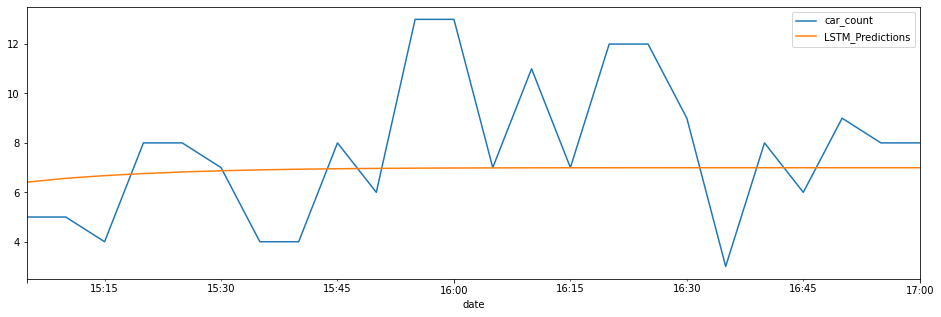

In [19]:
lstm_model.fit_generator(generator,epochs=5)

losses_lstm = lstm_model.history.history['loss']

lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)
    
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
test_data['LSTM_Predictions'] = lstm_predictions

test_data['car_count'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);
lstm_rmse_error = rmse(test_data['car_count'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['car_count'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')


## Conclusion

As per the above results, it is clear that LSTM follows the trend to forecast. Further improvements can be done by: 
* Adding more data. Currently only 3 days of data is being used. 
* Refine the parameters from object detection. The confidence metrics can be used to further refine the correct bounding boxes. 
* Other seasonal forecasting algorithms such as SARIMAX can be tried out. 
* Weather data was not available for the given (lat, long) location. The weather information from the nearest location can be used. 
* Additional features will make it multivariate analysis, making it further accurate and further interesting to solve. 